In [163]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI & SKTIME ****************
stable = False # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
!pip install sktime -U  >> /dev/null

  Running command git clone -q https://github.com/timeseriesAI/tsai.git /tmp/pip-req-build-3mr0bypm
  ERROR: Error [Errno 2] No such file or directory: 'git' while executing command git clone -q https://github.com/timeseriesAI/tsai.git /tmp/pip-req-build-3mr0bypm
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [1]:
from tsai.basics import *
import sktime
import sklearn
my_setup(sktime, sklearn)

os             : Linux-5.13.0-41-generic-x86_64-with-glibc2.17
python         : 3.8.12
tsai           : 0.3.1
fastai         : 2.6.3
fastcore       : 1.4.3
sktime         : 0.11.4
sklearn        : 1.0.2
torch          : 1.11.0
device         : 1 gpu (['NVIDIA GeForce RTX 3070 Laptop GPU'])
cpu cores      : 16
RAM            : 15.0 GB
GPU memory     : [8.0] GB


In [2]:
from tsai.models.MINIROCKET import *

In [3]:
path_to_data = "./"

In [4]:
df = pd.read_csv('dataset_with_rain_and_atm.csv')

In [5]:
df

,Timestamp,Value-1002-zeya-malayasazanka,Value-1003-zeya-svobodny,Value-2366-zeya-blagoveshensk,Value-316-zeya-mazanovo,Value-317-zeya-belogorye,snow_high,snow_level,snow_Q1,1.2,1.3,0.1,4,9,8,20,1.4,41,0.3,21.00
0,2008-01-01,435,163,148,218,341,4.0,10.0,0.0,1.0,1.0,12.0,8.0,21.0,8.0,20.0,1.0,11.0,0.0,11.2
1,2008-01-02,441,162,151,222,350,4.0,10.0,0.0,1.0,2.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.0
2,2008-01-03,447,161,157,226,361,4.0,10.0,0.0,1.0,3.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.0
3,2008-01-04,447,154,163,230,367,4.0,10.0,0.0,1.0,4.0,0.0,4.0,9.0,8.0,20.0,1.0,11.0,0.0,22.3
4,2008-01-05,443,144,168,222,364,4.0,10.0,0.0,1.0,5.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,14.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,2020-12-27,434,167,134,235,343,5.0,10.0,0.0,12.0,27.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.4
4745,2020-12-28,435,169,134,235,343,5.0,10.0,0.0,12.0,28.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.0
4746,2020-12-29,438,171,132,232,342,5.0,10.0,0.0,12.0,27.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.4
4747,2020-12-30,437,137,132,237,366,5.0,10.0,0.0,12.0,27.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.4


In [6]:
X = df[df.keys()[2:]].to_numpy()

In [7]:
X.shape

(4749, 18)

In [171]:
number_of_frames = X.shape[1]

In [8]:
def transform_to_types(x):
    if x < 450:
        return 0
    if x < 830:
        return 1
    if x < 855:
        return 2
    return 3
def transform_np_array(array):
    np_f = np.vectorize(transform_to_types)
    return np_f(array)

In [9]:
def create_dataset(df, num_days=365):
    number_of_frames = df[df.keys()[1:]].to_numpy().shape[1]
    X = df[df.keys()[1:]].to_numpy().reshape(-1, number_of_frames, 1)
    array_for_concat = []
    for i in range(num_days):
        array_for_concat.append(X[i:X.shape[0]-(num_days - i)])
    new_X = np.concatenate(array_for_concat, axis=-1)
    y = df['Value-2366-zeya-blagoveshensk'].to_numpy()[num_days:]
    
    return new_X, y

In [10]:
def create_multiple_dataset(df, num_days=365, days_forward=1):
    number_of_frames = df[df.keys()[1:]].to_numpy().shape[1]
    X = df[df.keys()[1:]].to_numpy().reshape(-1, number_of_frames, 1)
    array_for_concat = []
    for i in range(num_days):
        array_for_concat.append(X[i:X.shape[0]-(num_days - i)-days_forward+1])
    new_X = np.concatenate(array_for_concat, axis=-1)
    y = df['Value-2366-zeya-blagoveshensk'].to_numpy().reshape(-1, 1)
    array_for_concat = []
    for i in range(days_forward):
        array_for_concat.append(y[num_days+i:y.shape[0] - (days_forward - i - 1)])
    new_y = np.concatenate(array_for_concat, axis=-1)
    
    return new_X, new_y

In [11]:
def create_multiple_dataset_preprocessed(df, num_days=365, days_forward=1):
    number_of_frames = df[df.keys()[1:]].to_numpy().shape[1]
    X = df[df.keys()[1:]].to_numpy().reshape(-1, number_of_frames, 1)
    array_for_concat = []
    for i in range(num_days):
        array_for_concat.append(X[i:X.shape[0]-(num_days - i)-days_forward+1])
    new_X = np.concatenate(array_for_concat, axis=-1)
    y = df['Value-2366-zeya-blagoveshensk'].to_numpy().reshape(-1, 1)
    array_for_concat = []
    for i in range(days_forward):
        array_for_concat.append(y[num_days+i:y.shape[0] - (days_forward - i - 1)])
    new_y = np.concatenate(array_for_concat, axis=-1)
    
    return new_X / np.linalg.norm(new_X), new_y / np.linalg.norm(new_y)

In [12]:
def create_single_dataset(df, num_days=365, days_forward=1):
    number_of_frames = df[df.keys()[1:]].to_numpy().shape[1]
    X = df[df.keys()[1:]].to_numpy().reshape(-1, number_of_frames, 1)
    array_for_concat = []
    for i in range(num_days):
        array_for_concat.append(X[i:X.shape[0]-(num_days - i)-days_forward+1])
    new_X = np.concatenate(array_for_concat, axis=-1)
    y = df['Value-2366-zeya-blagoveshensk'].to_numpy().reshape(-1, 1)
    array_for_concat = []
    for i in range(days_forward):
        array_for_concat.append(y[num_days+i:y.shape[0] - (days_forward - i - 1)])
    new_y = np.concatenate(array_for_concat, axis=-1)
    return new_X, new_y[:, -1]

In [13]:
def create_multiple_dataset_preprocessed(df, num_days=365, days_forward=1):
    number_of_frames = df[df.keys()[1:]].to_numpy().shape[1]
    X = df[df.keys()[1:]].to_numpy().reshape(-1, number_of_frames, 1)
    array_for_concat = []
    for i in range(num_days):
        array_for_concat.append(X[i:X.shape[0]-(num_days - i)-days_forward+1])
    new_X = np.concatenate(array_for_concat, axis=-1)
    y = df['Value-2366-zeya-blagoveshensk'].to_numpy().reshape(-1, 1)
    array_for_concat = []
    for i in range(days_forward):
        array_for_concat.append(y[num_days+i:y.shape[0] - (days_forward - i - 1)])
    new_y = np.concatenate(array_for_concat, axis=-1)
    
    return new_X / np.linalg.norm(new_X), new_y / np.linalg.norm(new_y)

In [14]:
def help_function(df, num_days=365, days_forward=1):
    number_of_frames = df[df.keys()[1:]].to_numpy().shape[1]
    X = df[df.keys()[1:]].to_numpy().reshape(-1, number_of_frames, 1)
    array_for_concat = []
    for i in range(num_days):
        array_for_concat.append(X[i:X.shape[0]-(num_days - i)-days_forward+1])
    new_X = np.concatenate(array_for_concat, axis=-1)
    #y = df['Value-2366-zeya-blagoveshensk'].to_numpy().reshape(-1, 1)
    '''array_for_concat = []
    for i in range(days_forward):
        array_for_concat.append(y[num_days+i:y.shape[0] - (days_forward - i - 1)])
    new_y = np.concatenate(array_for_concat, axis=-1)'''
    
    return new_X

In [15]:
def create_data_set_without_blagoveshensk(df, num_days=365, days_forward=1):
    X, y = create_multiple_dataset(df, num_days,  days_forward)
    X = help_function(df.drop(['Value-2366-zeya-blagoveshensk'], axis=1), num_days, days_forward)
    return X, y

In [19]:
X, y = create_multiple_dataset(df, 365, 1)
y = transform_np_array(y)
np.unique(y)

array([0, 1])

In [18]:
X.shape, y.shape

((4384, 19, 365), (4384, 1))

In [181]:
y

array([[143],
       [148],
       [140],
       ...,
       [132],
       [132],
       [131]])

In [182]:
X = df1['Value'].to_numpy()
X = X.reshape(-1, 1)

NameError: name 'df1' is not defined

In [183]:
def make_ts(n):
    res = []
    for i in range(n + 1):
        res.append(X[i:6401-(n - i)])
    return res

In [184]:
def make_dataset_from_x(n):
    X11 = np.concatenate(np.array(make_ts(n)), axis=1)[:-1].reshape((-1, 1, n + 1))
    y1 = X[n + 1:]
    return X11, y1

In [185]:
X1, y = make_dataset_from_x(364)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4384 and the array at index 1 has size 4383

In [186]:
1 - float((X.shape[0] - 10) / X.shape[0])

0.0022810218978102093

In [20]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [21]:
from sklearn.model_selection import train_test_split
valid_leng = 1 - float((X.shape[0] - 10) / X.shape[0])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True)
#X_train, X_, y_train, y_ = train_test_split(X_train, y_train, test_size=0, shuffle=True)
#X_train, X_valid, y_trai, y_valid = train_test_split(X, y, , shuffle=False)z
print(y_train.shape)
X_train, y_train = unison_shuffled_copies(X_train, y_train)
y_train.shape

(3068, 1)


(3068, 1)

In [30]:
# Univariate regression with sklearn-type API
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = MiniRocketClassifier()
#print(model)
timer.start(False)
model.fit(X_train, y_train)
t = timer.stop()
y_pred = model.predict(X_valid)
#rmse = mean_squared_error(y_valid, y_pred, squared=False)
#mae = mean_absolute_error(y_valid, y_pred)
print(f'valid accuracy    : {model.score(X_valid, y_valid):.3%} time: {t}')

valid accuracy    : 99.772% time: 0:00:25.912026


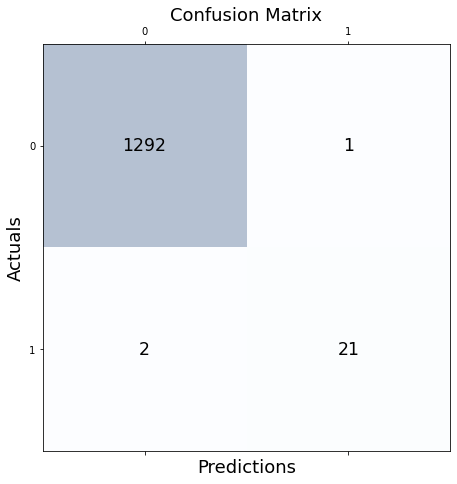

In [35]:
#
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Get the predictions
#
#y_pred = pipeline.predict(X_test)
#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_valid, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

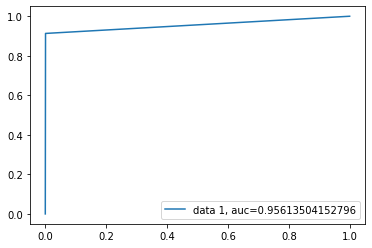

In [45]:
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_valid,  y_pred)
auc = metrics.roc_auc_score(y_valid, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [36]:
#make grahs
import matplotlib.pyplot as plt
valid_value = []
predicted_value = []
for i in range(len(y_valid[0])):
    valid_value.append([])
    predicted_value.append([])
for valid, pred in zip(y_valid, y_pred):
    for i in range(len(valid)):
        valid_value[i].append(valid[i])
        predicted_value[i].append(pred[i])
for valid, pred in zip(valid_value, predicted_value):
    plt.plot(valid, color='r', label='valid')
    plt.plot(pred, color='g', label='predicted')
    plt.legend()
    plt.show()

IndexError: invalid index to scalar variable.

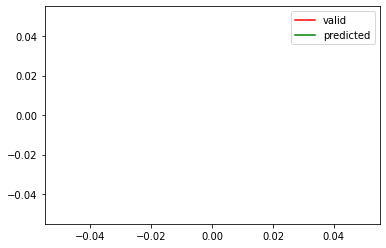

In [37]:
#make grahs for extreeme levels
import matplotlib.pyplot as plt
CRITICAL_LEVEL = 510
valid_value = []
predicted_value = []
for i in range(len(y_valid[0])):
    valid_value.append([])
    predicted_value.append([])
for valid, pred in zip(y_valid, y_pred):
    for i in range(len(valid)):
        if valid[i] >= CRITICAL_LEVEL:
            valid_value[i].append(valid[i])
            predicted_value[i].append(pred[i])
for valid, pred in zip(valid_value, predicted_value):
    plt.plot(valid, color='r', label='valid')
    plt.plot(pred, color='g', label='predicted')
    plt.legend()
    plt.show()

In [38]:
error_value = []
#for i in range(len(y_valid[0])):
#    error_value.append( abs(y_valid[:, i] - y_pred[:, i]) / y_valid[:, i])
plt.plot(abs(y_valid - y_pred) / y_valid, color='r', label='error_change')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [39]:
#make grahs
from tqdm import tqdm
import matplotlib.pyplot as plt
valid_value = []
predicted_value = []
for i in tqdm(range(len(X_train[0]))):
    valid_value.append([])
    predicted_value.append([])
for valid, pred in tqdm(zip(y_train, model.predict(X_train))):
    for i in range(len(valid)):
        valid_value[i].append(valid[i])
        predicted_value[i].append(pred[i])
for valid, pred in zip(valid_value, predicted_value):
    plt.plot(valid, color='r', label='valid')
    plt.plot(pred, color='g', label='predicted')
    plt.legend()
    plt.show()

100%|██████████| 19/19 [00:00<00:00, 63753.42it/s]
0it [00:00, ?it/s]


IndexError: invalid index to scalar variable.

In [196]:
np.mean(mean_absolute_error(y_valid[:, i], y_pred[:, i]) / y_valid[:, i])

0.2103277628941068

In [143]:
mean_absolute_error(y_valid[:][0], y_pred[:][0])

81.35398979245485

In [44]:
model.save(path='')

In [ ]:
# Multivariate regression ensemble with sklearn-type API
from sklearn.metrics import mean_squared_error, make_scorer
dsid = 'AppliancesEnergy'
#X_train, y_train, X_valid, y_valid = get_Monash_regression_data(dsid)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = MiniRocketVotingRegressor(n_estimators=5, scoring=rmse_scorer)
timer.start(False)
model.fit(X_train, y_train)
t = timer.stop()
y_pred = model.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'valid rmse        : {rmse:.5f} time: {t}')

valid rmse        : 17.40281 time: 0:04:32.796178


Git Gud

In [ ]:
X1, y = make_dataset_from_x(364)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.3)
# Univariate regression with sklearn-type API
from sklearn.metrics import mean_squared_error, make_scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = MiniRocketRegressor(scoring=rmse_scorer)
timer.start(False)
model.fit(X_train, y_train)
t = timer.stop()
y_pred = model.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'valid rmse        : {rmse:.5f} time: {t}')

valid rmse        : 17.42633 time: 0:00:55.231976


In [ ]:
X1, y = make_dataset_from_x(364)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.3)
# Univariate regression with sklearn-type API
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
rmse_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
model = MiniRocketRegressor(scoring=rmse_scorer)
timer.start(False)
model.fit(X_train, y_train)
t = timer.stop()
y_pred = model.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmae = mean_absolute_error(y_valid, y_pred)
print(f'valid rmae        : {rmae:.5f} time: {t}')
print(f'valid rmse        : {rmse:.5f} time: {t}')

valid rmae        : 10.57843 time: 0:00:57.012433
valid rmse        : 16.33624 time: 0:00:57.012433


In [ ]:
X1, y = make_dataset_from_x(364)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.3)
# Univariate regression with sklearn-type API
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = MiniRocketRegressor(scoring=rmse_scorer)
timer.start(False)
model.fit(X_train, y_train)
t = timer.stop()
y_pred = model.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmae = mean_absolute_error(y_valid, y_pred)
print(f'valid rmae        : {rmae:.5f} time: {t}')
print(f'valid rmse        : {rmse:.5f} time: {t}')

valid rmae        : 10.50202 time: 0:00:55.080953
valid rmse        : 20.33315 time: 0:00:55.080953


In [ ]:
# Multivariate regression ensemble with sklearn-type API
from sklearn.metrics import mean_squared_error, make_scorer
dsid = 'AppliancesEnergy'
#X_train, y_train, X_valid, y_valid = get_Monash_regression_data(dsid)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = MiniRocketVotingRegressor(n_estimators=5, scoring=rmse_scorer)
timer.start(False)
model.fit(X_train, y_train)
t = timer.stop()
y_pred = model.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmae = mean_absolute_error(y_valid, y_pred)
print(f'valid rmae        : {rmae:.5f} time: {t}')
print(f'valid rmse        : {rmse:.5f} time: {t}')

valid rmae        : 9.70839 time: 0:04:08.225762
valid rmse        : 21.58727 time: 0:04:08.225762


In [ ]:
# Multivariate regression ensemble with sklearn-type API
from sklearn.metrics import mean_squared_error, make_scorer
dsid = 'AppliancesEnergy'
#X_train, y_train, X_valid, y_valid = get_Monash_regression_data(dsid)
rmse_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
model = MiniRocketVotingRegressor(n_estimators=5, scoring=rmse_scorer)
timer.start(False)
model.fit(X_train, y_train)
t = timer.stop()
y_pred = model.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmae = mean_absolute_error(y_valid, y_pred)
print(f'valid rmae        : {rmae:.5f} time: {t}')
print(f'valid rmse        : {rmse:.5f} time: {t}')

valid rmae        : 9.71250 time: 0:04:05.586424
valid rmse        : 21.82798 time: 0:04:05.586424


In [ ]:
!pip install pycaret


     |████████████████████████████████| 320 kB 7.8 MB/s 
     |████████████████████████████████| 2.0 MB 46.2 MB/s 
     |████████████████████████████████| 88 kB 5.8 MB/s 
     |████████████████████████████████| 262 kB 46.8 MB/s 
     |████████████████████████████████| 167 kB 54.0 MB/s 
     |████████████████████████████████| 56 kB 2.9 MB/s 
     |████████████████████████████████| 1.3 MB 48.0 MB/s 
     |████████████████████████████████| 17.8 MB 272 kB/s 
     |████████████████████████████████| 3.3 MB 34.8 MB/s 
     |████████████████████████████████| 120 kB 54.2 MB/s 
     |████████████████████████████████| 1.7 MB 44.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8 MB 43.7 MB/s 
     |████████████████████████████████| 15.3 MB 36.6 MB/s 
     |████████████████████████████████| 26.3 MB 59.1 MB/s 
     |████████████████